<a href="https://colab.research.google.com/github/redrodion/LorentzMLtutorial/blob/main/Copy_of_MLtutorial_dip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep image prior for (DIP) image denoising

**For Colab user**
install astra-toolbox, tomosipo
**This may take up to 5 minutes!**

In [2]:
! apt install build-essential autoconf libtool
! pip install cython
! git clone https://github.com/astra-toolbox/astra-toolbox.git
! cd astra-toolbox/build/linux && ./autogen.sh && ./configure --with-cuda=/usr/local/cuda --with-python --with-install-type=module
! cd astra-toolbox/build/linux && make install -j 4
! pip install git+https://github.com/ahendriksen/tomosipo.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
autoconf is already the newest version (2.71-2).
autoconf set to manually installed.
build-essential is already the newest version (12.9ubuntu3).
Suggested packages:
  libtool-doc gcj-jdk
The following NEW packages will be installed:
  libtool
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 164 kB of archives.
After this operation, 1,227 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libtool all 2.4.6-15build2 [164 kB]
Fetched 164 kB in 1s (167 kB/s)
Selecting previously unselected package libtool.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../libtool_2.4.6-15build2_all.deb ...
Unpacking libtool (2.4.6-15build2) ...
Setting up libtool (2.4.6-15build2) ...
Processing triggers for man-db (2.10.2-1) ...
Cloning into 'astra-toolbox'...
remote: Enumerating objects: 11

In [3]:
import sys
sys.path.append('/usr/local/lib/python3.10/dist-packages/astra_toolbox-2.1.3-py3.10-linux-x86_64.egg')


In [4]:
import torch
print(torch.__version__)
import torch.nn as nn
import astra
import tomosipo as ts
import numpy as np
from imageio import imread, imwrite
from tomosipo.torch_support import to_autograd
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

2.1.0+cu118


Set to use GPU

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


**For Colab user**:

Option 1: To access the image, please follow the instructions:


1.   Save the [folder](https://drive.google.com/drive/folders/1larjCPxZ-e33B3UjjhiBUG0OAyF19aj3?usp=drive_link) to your own google drive by select folder -> organise -> Add shortcut -> All locations -> My drive
2.   Use the **code block below** to mount the files with the directory in your drive

In [6]:
from google.colab import drive
drive.mount('/content/drive/')
!cp "/content/drive/MyDrive/MLtutorial@Lorentz/lung_small.png" "./lung_small.png"

Mounted at /content/drive/


Option 2:
 **Warning!** This is often slower and dependent on the internet connection! Only consider it when the first option doesn't work

1.  Clone the files from github repostory [MLtutorial@Lorentz](https://github.com/jiayangshi/MLtutorial-Lorentz)
2.   Use the **code block below** to upload the files to current colab notebook

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Define a network for reconstruction
Bauger et al., Inverse Problem 2020
https://github.com/oterobaguer

In [7]:
class Skip(nn.Module):
    def __init__(self, in_ch, out_ch, skip_channels=(4, 4, 4, 4), channels=(8, 16, 32, 64)):
        super(Skip, self).__init__()
        self.scales = len(channels)
        assert(len(channels) == len(skip_channels))

        self.down = nn.ModuleList()
        self.up = nn.ModuleList()

        cur_ch = in_ch
        channels = [cur_ch] + list(channels)
        for i in range(self.scales):
            self.down.append(nn.Sequential(
                ConvolutionBlock(cur_ch, channels[i+1], stride=2),
                ConvolutionBlock(channels[i+1], channels[i+1], stride=1)))
            cur_ch = channels[i+1]

        for i in range(self.scales):
            self.up.append(UpBlock(
                in_ch=cur_ch,
                out_ch=channels[-i-1],
                skip_in_ch=channels[-i-2],
                skip_out_ch=skip_channels[-i-1]))
            cur_ch = channels[-i-1]

        self.outc = ConvolutionBlock(
            cur_ch, out_ch, kernel_size=1, use_bn=False, use_act=False)

    def forward(self, x0):
        xs = [x0]
        for i in range(self.scales):
            xs.append(self.down[i](xs[-1]))
        x = xs[-1]
        for i in range(self.scales):
            x = self.up[i](x, xs[-2-i])
        # return self.outc(x)
        return torch.sigmoid(self.outc(x))


class ConvolutionBlock(nn.Module):
    def __init__(self, in_f, out_f, kernel_size=3, stride=1, use_bias=True,
                 pad='reflection', use_bn=True, use_act=True):
        super(ConvolutionBlock, self).__init__()
        to_pad = int((kernel_size - 1) / 2)
        if pad == 'reflection':
            self.pad = nn.ReflectionPad2d(to_pad)
        else:
            self.pad = nn.ZeroPad2d(to_pad)
        self.convolution = nn.Conv2d(
            in_f, out_f, kernel_size, stride, bias=use_bias)
        self.bn = nn.BatchNorm2d(out_f)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.use_bn = use_bn
        self.use_act = use_act

    def forward(self, x):
        x = self.convolution(self.pad(x))
        if self.use_bn:
            x = self.bn(x)
        if self.use_act:
            x = self.act(x)
        return x


class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, skip_in_ch, skip_out_ch=4,
                 kernel_size=3):
        super(UpBlock, self).__init__()
        self.skip = skip_out_ch > 0
        if skip_out_ch == 0:
            skip_out_ch = 1
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        self.skip_conv = ConvolutionBlock(
            skip_in_ch, skip_out_ch, kernel_size=1)
        self.concat = Concat()
        self.conv = nn.Sequential(ConvolutionBlock(in_ch + skip_out_ch, out_ch,
                                                   kernel_size=kernel_size),
                                  ConvolutionBlock(out_ch, out_ch,
                                                   kernel_size=1))

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x2 = self.skip_conv(x2)
        if not self.skip:
            x2 = x2 * 0
        x = self.concat(x1, x2)
        x = self.conv(x)
        return x


class Concat(nn.Module):
    def __init__(self):
        super(Concat, self).__init__()

    def forward(self, *inputs):
        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs:
                diff2 = (inp.size(2) - target_shape2) // 2
                diff3 = (inp.size(3) - target_shape3) // 2
                inputs_.append(
                    inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])
        return torch.cat(inputs_, dim=1)

create tomograhic operators in tomosipo

In [8]:
angles = np.linspace(0, np.pi, 40, endpoint=False)
vg = ts.volume(shape=(1, 256, 256), size=(1, 256, 256))
pg = ts.parallel(angles=angles, shape=(1, 256), size=(1, 256))
A = ts.operator(vg, pg)
f = to_autograd(A, is_2d=True)

Create circle mask to remove the the corners

In [9]:
# ref: tomopy.misc.corr.circ_mask https://tomopy.readthedocs.io/en/latest/_modules/tomopy/misc/corr.html#circ_mask
def _get_mask(dx, dy, ratio):
    """
    Calculate 2D boolean circular mask.

    Parameters
    ----------
    dx, dy : int
        Dimensions of the 2D mask.

    ratio : int
        Ratio of the circle's diameter in pixels to
        the smallest mask dimension.

    Returns
    -------
    ndarray
        2D boolean array.
    """
    rad1 = dx / 2.
    rad2 = dy / 2.
    if dx < dy:
        r2 = rad1 * rad1
    else:
        r2 = rad2 * rad2
    y, x = np.ogrid[0.5 - rad1:0.5 + rad1, 0.5 - rad2:0.5 + rad2]
    return x * x + y * y < ratio * ratio * r2

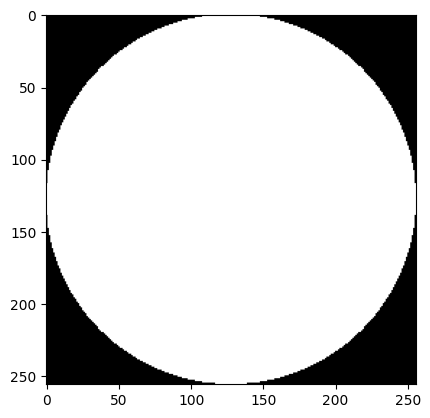

In [10]:
mask_np = _get_mask(256,256,1)
mask = torch.tensor(mask_np, dtype=torch.float32, device=device)
plt.imshow(mask.cpu().numpy(), cmap='gray')

create projection using forward operator f

In [11]:
img = imread('lung_small.png')
img = img / img.max()
# img = np.expand_dims(img, axis=0)
print(f"Shape of img: {img.shape}")
img = torch.tensor(img, dtype=torch.float32)
projs = f(img)
print(f"Shape of projs: {projs.shape}")
projs = projs.to(device)

Shape of img: (256, 256)
Shape of projs: torch.Size([40, 256])


<ipython-input-11-ceb6ca258986>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('lung_small.png')


Visualize the ground-truth and simulated sinogram

Text(0.5, 1.0, 'Projections')

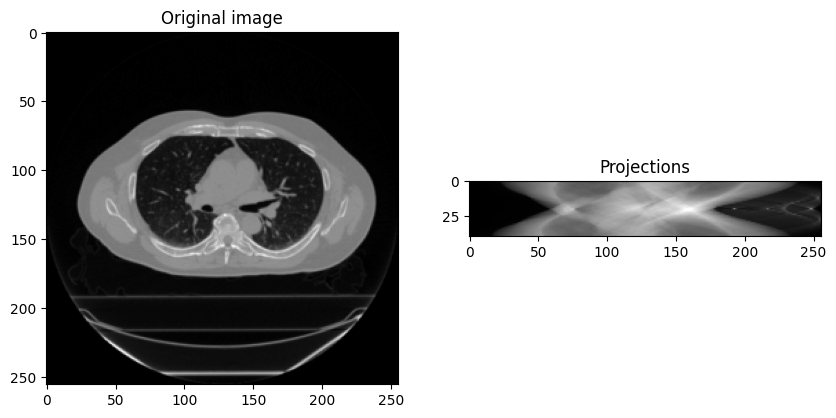

In [12]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(projs.cpu().numpy(), cmap='gray')
plt.title('Projections')

Define the iteration, model, optimizer and loss function

In [13]:
epochs = 8000

model = Skip(in_ch=1, out_ch=1, skip_channels=(4, 4, 4, 4), channels=(8, 16, 32, 64))

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
model = model.to(device)
mse_loss = nn.MSELoss()

optimization

  0%|          | 0/8000 [00:00<?, ?it/s]

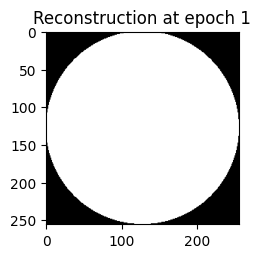

 12%|█▏        | 996/8000 [00:22<02:09, 54.01it/s]

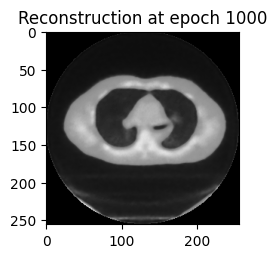

 25%|██▍       | 1998/8000 [00:37<01:24, 70.65it/s]

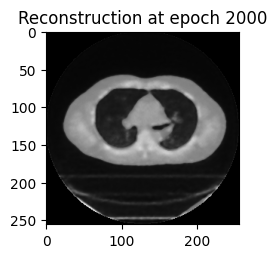

 37%|███▋      | 2998/8000 [00:52<01:07, 73.57it/s]

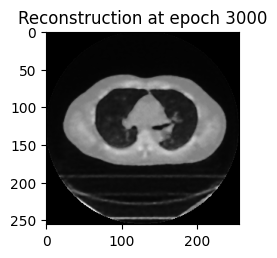

 50%|████▉     | 3998/8000 [01:07<00:54, 73.62it/s]

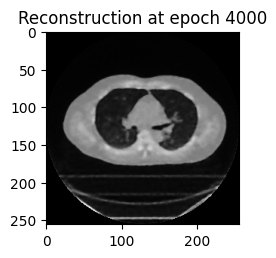

 62%|██████▏   | 4998/8000 [01:23<00:41, 72.80it/s]

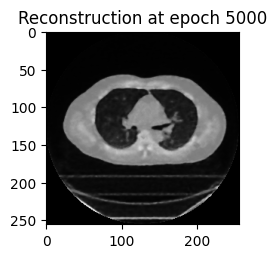

 75%|███████▍  | 5998/8000 [01:38<00:27, 73.39it/s]

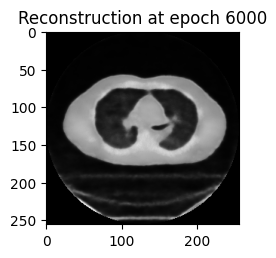

 87%|████████▋ | 6992/8000 [01:53<00:14, 68.28it/s]

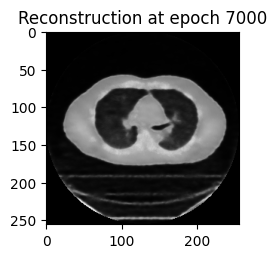

100%|█████████▉| 7997/8000 [02:09<00:00, 48.44it/s]

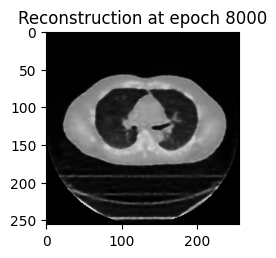

100%|██████████| 8000/8000 [02:09<00:00, 61.73it/s]


In [14]:
test_input = 0.1 * torch.randn((1,1,256,256)).to(device)
train_input = test_input
for epoch in tqdm(range(epochs)):
    if epoch == 0 or (epoch + 1) % 1000 == 0:
        model.eval()
        with torch.no_grad():

            test_output = model(test_input).squeeze()
            test_output = torch.mul(test_output, mask)
            plt.figure(figsize=(2.5, 2.5))
            plt.imshow(test_output.detach().cpu().numpy(), cmap='gray')
            plt.title(f"Reconstruction at epoch {epoch + 1}")
            plt.show()
            plt.close()
            # uncomment to save images
            # imwrite(f"reconstruction_epoch_{epoch + 1}.png", test_output.detach().cpu().numpy())

    model.train()
    optimizer.zero_grad()
    train_output = model(train_input).squeeze()
    train_output = torch.mul(train_output, mask)
    train_projs = f(train_output)
    train_loss = mse_loss(train_projs, projs)
    train_loss.backward()
    optimizer.step()


Comparison: FBP and SIRT

In [15]:
vg_astra = astra.create_vol_geom(256, 256)
pg_astra = astra.create_proj_geom('parallel', 1.0, 256, angles)
proj_id = astra.create_projector('cuda', pg_astra, vg_astra)
W = astra.OpTomo(proj_id)


In [16]:
recon_fbp = W.reconstruct('FBP_CUDA',projs.cpu().numpy())
recon_sirt = W.reconstruct('SIRT_CUDA',projs.cpu().numpy(),1000,{'MinConstraint':0,'MaxConstraint':1})

recon_fbp = recon_fbp * mask_np
recon_sirt = recon_sirt * mask_np
recon_fbp = recon_fbp[::-1,:]
recon_sirt = recon_sirt[::-1,:]

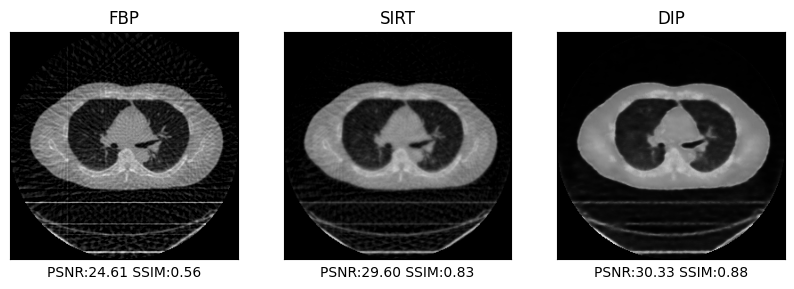

In [17]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(recon_fbp, vmin=0, vmax=1, cmap='gray')
plt.title('FBP')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlabel(f"PSNR:{psnr(recon_fbp,img.numpy(),data_range=1):.2f} SSIM:{ssim(recon_fbp,img.numpy(),data_range=1):.2f}", ha='center')
plt.subplot(1, 3, 2)
plt.imshow(recon_sirt, vmin=0, vmax=1, cmap='gray')
plt.title('SIRT')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlabel(f"PSNR:{psnr(recon_sirt,img.numpy(),data_range=1):.2f} SSIM:{ssim(recon_sirt,img.numpy(),data_range=1):.2f}", ha='center')
plt.subplot(1, 3, 3)
plt.imshow(test_output.detach().cpu().numpy(), vmin=0, vmax=1, cmap='gray')
plt.title('DIP')
plt.xlabel('')
plt.ylabel('')
plt.xlabel(f"PSNR:{psnr(test_output.detach().cpu().numpy(),img.numpy(),data_range=1):.2f} SSIM:{ssim(test_output.detach().cpu().numpy(),img.numpy(),data_range=1):.2f}", ha='center')
plt.xticks([])
plt.yticks([])

plt.show()